<h3>导入包</h3>

In [257]:
import os
import logging
from datetime import datetime
from typing import Optional, Union
from chinese_calendar import is_workday, is_holiday, is_in_lieu, get_holiday_detail
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import zipfile
from zipfile import ZipFile
import numpy as np
import pandas as pd
from pandas import DataFrame, Series, Timestamp, Timedelta, DatetimeIndex
import matplotlib.pyplot as plt
from tqdm import tqdm
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from sklearn.metrics import r2_score
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold
from sklearn.base import RegressorMixin
from sklearn.metrics import r2_score
import lightgbm as lgb
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, TimeDistributed, Dense, BatchNormalization
from tensorflow.keras.losses import MeanSquaredError, Huber
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.keras.backend import clear_session
from tensorflow.keras.preprocessing import timeseries_dataset_from_array
from tensorflow.keras.optimizers import Adam


# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
tf.random.set_seed(42)
warnings.filterwarnings('ignore')
logging.basicConfig(format='%(asctime)s [%(levelname)s] %(message)s', level=logging.INFO)

<h3>读入数据</h3>

In [258]:
sub_sheet_name = ["二层插座", "二层照明", "一层插座", "一层照明", "空调"]
data_dict = {}
for name in sub_sheet_name:
    data_dict[name] = pd.read_csv('../data/Data_A/' + name + '_EC.csv')
    data_dict[name]["time"] = pd.to_datetime(data_dict[name]["time"])
data_dict

{'二层插座':                      time     value
 0     2013-08-03 00:00:00  0.164062
 1     2013-08-03 00:15:00  0.121094
 2     2013-08-03 00:30:00  0.101562
 3     2013-08-03 00:45:00  0.087891
 4     2013-08-03 01:00:00  0.103516
 ...                   ...       ...
 63395 2015-08-03 22:45:00  0.082031
 63396 2015-08-03 23:00:00  0.128906
 63397 2015-08-03 23:15:00  0.125000
 63398 2015-08-03 23:30:00  0.082031
 63399 2015-08-03 23:45:00  0.160156
 
 [63400 rows x 2 columns],
 '二层照明':                      time     value
 0     2013-08-03 00:00:00  0.500000
 1     2013-08-03 00:15:00  0.507812
 2     2013-08-03 00:30:00  0.476562
 3     2013-08-03 00:45:00  0.117188
 4     2013-08-03 01:00:00  0.000000
 ...                   ...       ...
 63643 2015-08-03 22:45:00  0.000000
 63644 2015-08-03 23:00:00  0.000000
 63645 2015-08-03 23:15:00  0.000000
 63646 2015-08-03 23:30:00  0.000000
 63647 2015-08-03 23:45:00  0.000000
 
 [63648 rows x 2 columns],
 '一层插座':                      time    

<h3>读入天气数据</h3>

In [259]:
wh = pd.read_csv("../data/Data_A/天气.csv")
wh["日期"] = pd.to_datetime(wh["日期"])
wh["time"] = wh["日期"] + pd.to_timedelta(wh["小时"], "h")
wh.drop(["Unnamed: 0", "日期", "小时"], axis=1, inplace=True)
wh = wh.set_index("time", drop=True)
wh

,温度(C°),湿度(%),降雨量(mm),大气压(hPa),风向,风向角度(°),风速(KM/H),云量(%)
time,,,,,,,,
2013-08-03 00:00:00,28,88,1.0,1006,东南风,159,9,71
2013-08-03 01:00:00,28,88,0.9,1006,东南风,155,8,75
2013-08-03 02:00:00,28,89,0.7,1006,东南风,150,8,54
2013-08-03 03:00:00,27,90,0.5,1006,东南风,151,8,25
2013-08-03 04:00:00,27,90,0.2,1006,东南风,151,8,35
...,...,...,...,...,...,...,...,...
2015-08-24 19:00:00,27,67,0.0,1006,东北风,43,11,1
2015-08-24 20:00:00,26,72,0.0,1007,东北风,45,9,0
2015-08-24 21:00:00,25,75,0.4,1007,东北风,35,7,2


<h3>合并数据</h3>

<h4>对齐数据</h4>

In [260]:
data = pd.merge(data_dict["二层插座"],data_dict["二层照明"],on='time', how="inner", suffixes=("_socket_2","_light_2"))
data = pd.merge(data,data_dict["一层插座"],on='time', how="inner", suffixes=("","_socket_1"))
data = pd.merge(data,data_dict["一层照明"],on='time', how="inner", suffixes=("","_light_1"))
data = pd.merge(data,data_dict["空调"],on='time', how="inner", suffixes=("","_air"))
data = data.rename(columns={"value":"value_socket_1"})
data

,time,value_socket_2,value_light_2,value_socket_1,value_light_1,value_air
0,2013-08-03 00:00:00,0.164062,0.500000,0.113281,0.542969,4.234375
1,2013-08-03 00:15:00,0.121094,0.507812,0.273438,0.542969,5.093750
2,2013-08-03 00:30:00,0.101562,0.476562,0.277344,0.515625,3.234375
3,2013-08-03 00:45:00,0.087891,0.117188,0.218750,0.437500,3.187500
4,2013-08-03 01:00:00,0.103516,0.000000,0.082031,0.406250,3.171875
...,...,...,...,...,...,...
63160,2015-08-03 22:45:00,0.082031,0.000000,0.097656,0.250000,2.250000
63161,2015-08-03 23:00:00,0.128906,0.000000,0.175781,0.242188,2.343750
63162,2015-08-03 23:15:00,0.125000,0.000000,0.101562,0.226562,2.093750
63163,2015-08-03 23:30:00,0.082031,0.000000,0.164062,0.171875,2.312500


<h4>将一二层数据相加</h4>

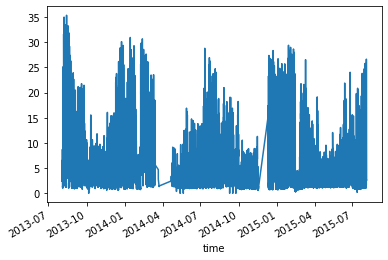

In [261]:
data["value_socket"] = data["value_socket_2"] + data["value_socket_1"]
data["value_light"] = data["value_light_2"] + data["value_light_1"]
data.drop(['value_socket_2','value_light_2','value_socket_1','value_light_1'], axis=1, inplace=True)
data["value_total"] = data.sum(axis=1)
data = data.set_index("time", drop=True)
# data = data.reindex(pd.date_range(start=data.index[0], end=data.index[-1], freq="15T"))
data["value_total"].plot()

<h3>处理缺失值</h3>

<h4>查看大段的nan</h4>

In [262]:
data.loc['2014-03-14 13:00:00' : '2014-04-23 20:15:00']

,value_air,value_socket,value_light,value_total
time,,,,
2014-03-14 13:00:00,2.43750,1.539062,1.710938,5.687500
2014-03-14 13:15:00,2.37500,1.769531,1.777344,5.921875
2014-03-14 13:30:00,2.37500,1.347656,1.882812,5.605469
2014-03-21 18:45:00,1.93750,1.443359,1.316406,4.697266
2014-03-21 19:00:00,1.00000,1.242188,1.320312,3.562500
2014-03-21 19:15:00,0.93750,1.421875,1.304688,3.664062
2014-03-21 19:30:00,1.00000,0.763672,1.023438,2.787109
2014-03-23 19:00:00,0.93750,0.289062,0.179688,1.406250
2014-03-23 19:15:00,0.90625,0.253906,0.171875,1.332031


In [263]:
data.loc['2014-11-17 08:00:00' : '2014-12-10 17:15:00']

,value_air,value_socket,value_light,value_total
time,,,,
2014-11-17 08:00:00,0.59375,0.390625,0.320312,1.304688
2014-11-17 08:15:00,0.59375,0.207031,0.281250,1.082031
2014-12-10 16:45:00,11.62500,1.718750,2.039062,15.382812
2014-12-10 17:00:00,12.15625,1.757812,2.039062,15.953125
2014-12-10 17:15:00,11.75000,1.531250,2.019531,15.300781


<h4>查看所有缺失值的index，并将该小时的Timestamp记录下来</h4>

In [264]:
nan_index = data[data["value_total"].isnull()].index
nan_index_hours = []
for idx in nan_index:
    nan_index_hour = Timestamp(year=idx.year, month=idx.month, day=idx.day, hour=idx.hour)
    nan_index_hours.append(nan_index_hour)
nan_index_hours = np.unique(nan_index_hours)
DatetimeIndex(nan_index_hours)

DatetimeIndex([], dtype='datetime64[ns]', freq=None)

<h4>对少数缺失值进行插值补全</h4>

In [265]:
# data["value_air"] = data["value_air"].interpolate(method="linear")
# data["value_light"] = data["value_light"].interpolate(method="linear")
# data["value_socket"] = data["value_socket"].interpolate(method="linear")
# data["value_total"] = data["value_total"].interpolate(method="linear")

<h3>按照每小时相加</h3>

In [266]:
data = data.resample("1H").sum()
# data.loc["2014-03-14 13:00:00" : "2014-04-23 20:00:00", :] = np.nan
# data.loc["2014-11-17 08:00:00" : "2014-12-10 16:00:00", :] = np.nan
# data = data.dropna()
data

,value_air,value_socket,value_light,value_total
time,,,,
2013-08-03 00:00:00,15.750000,1.357422,3.640625,20.748047
2013-08-03 01:00:00,12.390625,0.785156,1.621094,14.796875
2013-08-03 02:00:00,10.953125,0.771484,1.632812,13.357422
2013-08-03 03:00:00,11.343750,0.830078,1.613281,13.787109
2013-08-03 04:00:00,12.671875,1.162109,1.812500,15.646484
...,...,...,...,...
2015-08-03 19:00:00,22.593750,1.367188,2.851562,26.812500
2015-08-03 20:00:00,19.281250,1.402344,1.687500,22.371094
2015-08-03 21:00:00,16.312500,1.273438,1.609375,19.195312


<h3>合并天气数据</h3>

In [267]:
data = pd.merge(data, wh, how="right", left_index=True, right_index=True)
data

,value_air,value_socket,value_light,value_total,温度(C°),湿度(%),降雨量(mm),大气压(hPa),风向,风向角度(°),风速(KM/H),云量(%)
time,,,,,,,,,,,,
2013-08-03 00:00:00,15.750000,1.357422,3.640625,20.748047,28,88,1.0,1006,东南风,159,9,71
2013-08-03 01:00:00,12.390625,0.785156,1.621094,14.796875,28,88,0.9,1006,东南风,155,8,75
2013-08-03 02:00:00,10.953125,0.771484,1.632812,13.357422,28,89,0.7,1006,东南风,150,8,54
2013-08-03 03:00:00,11.343750,0.830078,1.613281,13.787109,27,90,0.5,1006,东南风,151,8,25
2013-08-03 04:00:00,12.671875,1.162109,1.812500,15.646484,27,90,0.2,1006,东南风,151,8,35
...,...,...,...,...,...,...,...,...,...,...,...,...
2015-08-24 19:00:00,NaN,NaN,NaN,NaN,27,67,0.0,1006,东北风,43,11,1
2015-08-24 20:00:00,NaN,NaN,NaN,NaN,26,72,0.0,1007,东北风,45,9,0
2015-08-24 21:00:00,NaN,NaN,NaN,NaN,25,75,0.4,1007,东北风,35,7,2


<h3>TODO 特征工程</h3>

<h4>修改列名</h4>

In [268]:
data = data.rename(columns={
    "温度(C°)":"temp",
    "湿度(%)":"humidity",
    "降雨量(mm)":"rainfall",
    "大气压(hPa)":"atmos",
    "风向":"wind_direction",
    "风向角度(°)":"wind_angle",
    "风速(KM/H)":"wind_speed",
    "云量(%)":"cloud"
})

<h4>自定义特征工程</h4>

In [269]:
data['workday'] = list(map(lambda x: int(is_workday(x)), data.index.to_list()))
data['hour'] = list(map(lambda x: x.hour, data.index.to_list()))
data['week'] = list(map(lambda x: x.weekday(), data.index.to_list()))
data['day'] = list(map(lambda x: x.day, data.index.to_list()))
data['month'] = list(map(lambda x: x.month, data.index.to_list()))
data['year'] = list(map(lambda x: x.year, data.index.to_list()))
# data = pd.concat([data.loc[: "2015-08-03 23:00:00"].dropna(), data.loc["2015-08-04 00:00:00" : "2015-08-10 23:00:00"]], axis=0)
data

,value_air,value_socket,value_light,value_total,temp,humidity,rainfall,atmos,wind_direction,wind_angle,wind_speed,cloud,workday,hour,week,day,month,year
time,,,,,,,,,,,,,,,,,,
2013-08-03 00:00:00,15.750000,1.357422,3.640625,20.748047,28,88,1.0,1006,东南风,159,9,71,0,0,5,3,8,2013
2013-08-03 01:00:00,12.390625,0.785156,1.621094,14.796875,28,88,0.9,1006,东南风,155,8,75,0,1,5,3,8,2013
2013-08-03 02:00:00,10.953125,0.771484,1.632812,13.357422,28,89,0.7,1006,东南风,150,8,54,0,2,5,3,8,2013
2013-08-03 03:00:00,11.343750,0.830078,1.613281,13.787109,27,90,0.5,1006,东南风,151,8,25,0,3,5,3,8,2013
2013-08-03 04:00:00,12.671875,1.162109,1.812500,15.646484,27,90,0.2,1006,东南风,151,8,35,0,4,5,3,8,2013
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-08-24 19:00:00,NaN,NaN,NaN,NaN,27,67,0.0,1006,东北风,43,11,1,1,19,0,24,8,2015
2015-08-24 20:00:00,NaN,NaN,NaN,NaN,26,72,0.0,1007,东北风,45,9,0,1,20,0,24,8,2015
2015-08-24 21:00:00,NaN,NaN,NaN,NaN,25,75,0.4,1007,东北风,35,7,2,1,21,0,24,8,2015


<h3>对类别特征onehot</h3>

<h4>对风向进行onehot</h4>

In [270]:
onehot_wind = OneHotEncoder(sparse=False)
onehot_wind.fit(data[["wind_direction"]])
data = pd.concat([data, DataFrame(onehot_wind.transform(data[["wind_direction"]]), columns=onehot_wind.categories_[0], index=data.index).astype(int)], axis=1)
data = data.drop(columns=["wind_direction"])
data

,value_air,value_socket,value_light,value_total,temp,humidity,rainfall,atmos,wind_angle,wind_speed,...,month,year,东北风,东南风,东风,北风,南风,西北风,西南风,西风
time,,,,,,,,,,,,,,,,,,,,,
2013-08-03 00:00:00,15.750000,1.357422,3.640625,20.748047,28,88,1.0,1006,159,9,...,8,2013,0,1,0,0,0,0,0,0
2013-08-03 01:00:00,12.390625,0.785156,1.621094,14.796875,28,88,0.9,1006,155,8,...,8,2013,0,1,0,0,0,0,0,0
2013-08-03 02:00:00,10.953125,0.771484,1.632812,13.357422,28,89,0.7,1006,150,8,...,8,2013,0,1,0,0,0,0,0,0
2013-08-03 03:00:00,11.343750,0.830078,1.613281,13.787109,27,90,0.5,1006,151,8,...,8,2013,0,1,0,0,0,0,0,0
2013-08-03 04:00:00,12.671875,1.162109,1.812500,15.646484,27,90,0.2,1006,151,8,...,8,2013,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-08-24 19:00:00,NaN,NaN,NaN,NaN,27,67,0.0,1006,43,11,...,8,2015,1,0,0,0,0,0,0,0
2015-08-24 20:00:00,NaN,NaN,NaN,NaN,26,72,0.0,1007,45,9,...,8,2015,1,0,0,0,0,0,0,0
2015-08-24 21:00:00,NaN,NaN,NaN,NaN,25,75,0.4,1007,35,7,...,8,2015,1,0,0,0,0,0,0,0


<h4>对星期几进行onehot</h4>

In [271]:
data["week"] = data["week"].apply(lambda x: "星期" + str(x + 1))
onehot_week = OneHotEncoder(sparse=False)
onehot_week.fit(data[["week"]])
data = pd.concat([data, DataFrame(onehot_week.transform(data[["week"]]), columns=onehot_week.categories_[0], index=data.index).astype(int)], axis=1)
data = data.drop(columns=["week"])
data

,value_air,value_socket,value_light,value_total,temp,humidity,rainfall,atmos,wind_angle,wind_speed,...,西北风,西南风,西风,星期1,星期2,星期3,星期4,星期5,星期6,星期7
time,,,,,,,,,,,,,,,,,,,,,
2013-08-03 00:00:00,15.750000,1.357422,3.640625,20.748047,28,88,1.0,1006,159,9,...,0,0,0,0,0,0,0,0,1,0
2013-08-03 01:00:00,12.390625,0.785156,1.621094,14.796875,28,88,0.9,1006,155,8,...,0,0,0,0,0,0,0,0,1,0
2013-08-03 02:00:00,10.953125,0.771484,1.632812,13.357422,28,89,0.7,1006,150,8,...,0,0,0,0,0,0,0,0,1,0
2013-08-03 03:00:00,11.343750,0.830078,1.613281,13.787109,27,90,0.5,1006,151,8,...,0,0,0,0,0,0,0,0,1,0
2013-08-03 04:00:00,12.671875,1.162109,1.812500,15.646484,27,90,0.2,1006,151,8,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-08-24 19:00:00,NaN,NaN,NaN,NaN,27,67,0.0,1006,43,11,...,0,0,0,1,0,0,0,0,0,0
2015-08-24 20:00:00,NaN,NaN,NaN,NaN,26,72,0.0,1007,45,9,...,0,0,0,1,0,0,0,0,0,0
2015-08-24 21:00:00,NaN,NaN,NaN,NaN,25,75,0.4,1007,35,7,...,0,0,0,1,0,0,0,0,0,0


<h3>构建模型</h3>

In [272]:
def r2_metric(y_pred, y_true):
    result1 = r2_score(y_true[0:24], y_pred[0:24])
    result2 = r2_score(y_true[24:48], y_pred[24:48])
    result3 = r2_score(y_true[48:72], y_pred[48:72])
    result4 = r2_score(y_true[72:96], y_pred[72:96])
    result5 = r2_score(y_true[96:120], y_pred[96:120])
    result6 = r2_score(y_true[120:144], y_pred[120:144])
    result7 = r2_score(y_true[144:168], y_pred[144:168])
    return "r2 score", 0.25 * result1 + 0.15 * (result2 + result3 + result4) + 0.1 * (result5 + result6 + result7), True

In [273]:
def cross_validation(estimator: RegressorMixin, n_splits: int, x_train_val: DataFrame, y_train_val: Series, x_test: DataFrame) -> np.ndarray:
    """
    交叉验证\n
    """
    models = []
    scores = []
    oof_preds = np.zeros((x_train_val.shape[0],))
    test_preds = np.zeros((x_test.shape[0],))
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    for fold, (train_index, val_index) in enumerate(kfold.split(x_train_val, y_train_val)):
        x_train, x_val, y_train, y_val = x_train_val.iloc[train_index], x_train_val.iloc[val_index], y_train_val[train_index], y_train_val[val_index]

        estimator = estimator.fit(x_train, y_train, eval_set=(x_val, y_val), eval_metric=r2_metric, early_stopping_rounds=20)
        models.append(estimator)

        oof_preds[val_index] = estimator.predict(x_val, num_iteration=estimator.best_iteration_)
        test_preds += estimator.predict(x_test, num_iteration=estimator.best_iteration_) / kfold.n_splits
        score = r2_score(y_val, estimator.predict(x_val, num_iteration=estimator.best_iteration_))
        
        logging.info(f'############ fold: {fold}, r2: {score} ###########')
        scores.append(score)
    logging.info(f'############ cross validation r2 score: {np.mean(scores)} ###########')
    return test_preds

In [274]:
def shift_column(ser: Series, num: int) -> DataFrame:
    """
    取历史值\n
    """
    result = DataFrame()
    for i in range(1, num + 1):
        result["%s-%d" % (ser.name, i)] = ser.shift(i)
    return result

In [275]:
def clip_maxmin(ser: Series, _clip_min_: bool, _clip_max_: bool) -> Series:
    """
    把最小值最大值变为次小值次大值\n
    """
    result = ser.copy()
    if _clip_min_:
        idx = result.argmin()
        result[result == result.min()] = np.nan
        result.iloc[idx] = result.min()
    if _clip_max_:
        idx = result.argmax()
        result[result == result.max()] == np.nan
        result.iloc[idx] = result.max()
    return result

In [276]:
def clip_value(ser: Union[Series, np.ndarray], _min_val_: Optional[float] = None, _max_val_: Optional[float] = None) -> Series:
    """
    把小于最小值的替换成最小值\n
    """
    result = ser.copy()
    if _min_val_:
        result[result < _min_val_] = _min_val_
    if _max_val_:
        result[result > _max_val_] = _max_val_
    return result

<h4>针对socket构建模型</h4>

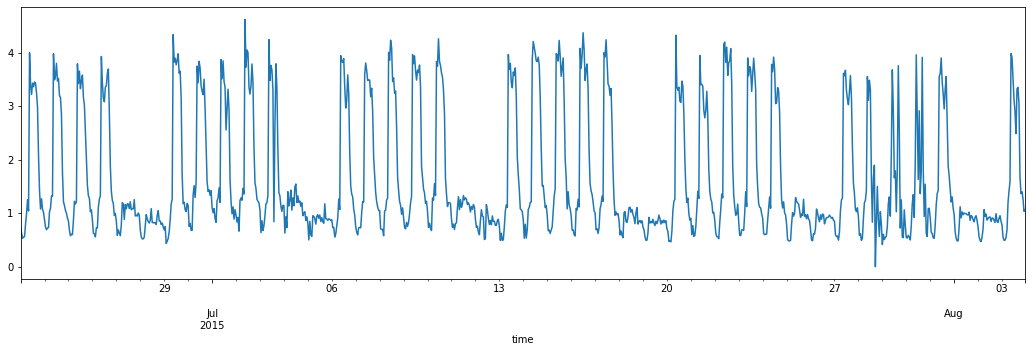

In [277]:
data["value_socket"].loc["2015-06-23 00:00:00" : "2015-08-03 23:00:00"].plot(figsize=(18,5))

In [278]:
data_socket = data.drop(columns=["value_light", "value_air", "value_total"])
x_train_socket = data_socket.drop(columns=["value_socket"]).loc[: "2015-08-03 23:00:00"]
y_train_socket = data_socket["value_socket"].loc[: "2015-08-03 23:00:00"]
x_test_socket = data_socket.drop(columns=["value_socket"]).loc["2015-08-04 00:00:00" : "2015-08-10 23:00:00"]

In [279]:
model_socket = LGBMRegressor(n_estimators=1000, n_jobs=-1, random_state=42).fit(x_train_socket, y_train_socket)
socket_pred = model_socket.predict(x_test_socket)

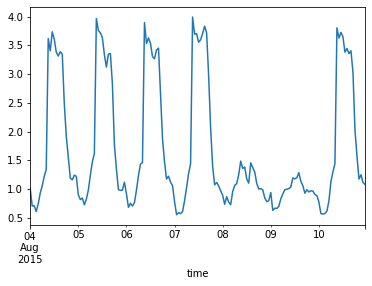

In [280]:
data_socket.loc["2015-08-04 00:00:00" : "2015-08-10 23:00:00", "value_socket"] = socket_pred
data_socket.loc["2015-08-04 00:00:00" : "2015-08-10 23:00:00", "value_socket"].plot()

<h4>针对light构建模型</h4>

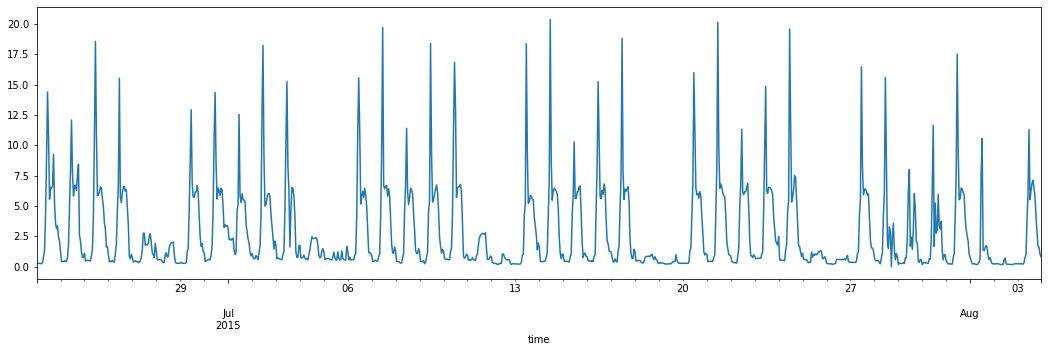

In [281]:
data["value_light"].loc["2015-06-23 00:00:00" : "2015-08-03 23:00:00"].plot(figsize=(18,5))

In [282]:
data_light = data.drop(columns=["value_socket", "value_air", "value_total", 'temp', 'humidity', 'atmos', 'wind_angle', 'wind_speed'])
x_train_light = data_light.drop(columns=["value_light"]).loc[: "2015-08-03 23:00:00"]
y_train_light = data_light["value_light"].loc[: "2015-08-03 23:00:00"]
x_test_light = data_light.drop(columns=["value_light"]).loc["2015-08-04 00:00:00" : "2015-08-10 23:00:00"]

In [283]:
model_light = LGBMRegressor(n_estimators=1000, n_jobs=-1, random_state=42).fit(x_train_light, y_train_light)
light_pred = model_light.predict(x_test_light)

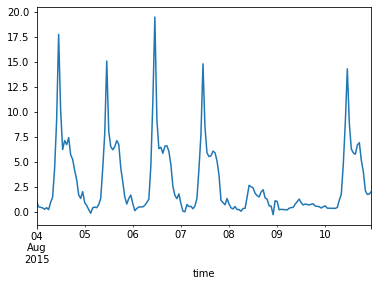

In [284]:
data_light.loc["2015-08-04 00:00:00" : "2015-08-10 23:00:00", "value_light"] = light_pred
data_light.loc["2015-08-04 00:00:00" : "2015-08-10 23:00:00", "value_light"].plot()

<h4>针对air构建模型</h4>

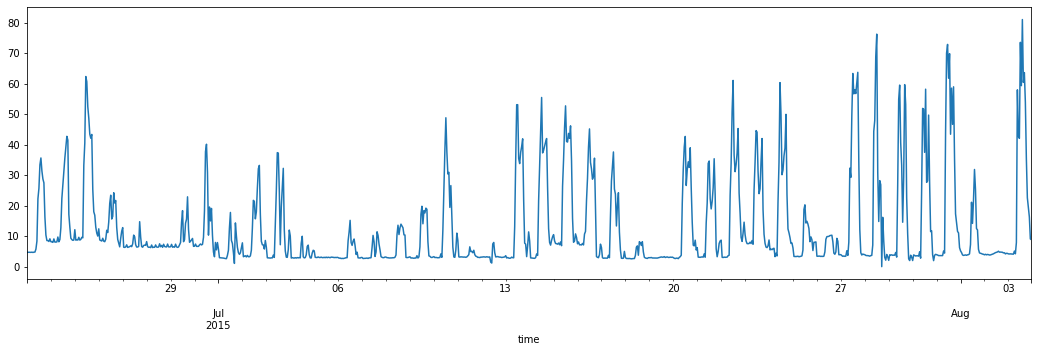

In [285]:
data["value_air"].loc["2015-06-23 00:00:00" : "2015-08-03 23:00:00"].plot(figsize=(18,5))

In [286]:
data_air = data.drop(columns=["value_socket", "value_light", "value_total"])
x_train_air = data_air.drop(columns=["value_air"]).loc[: "2015-08-03 23:00:00"]
y_train_air = data_air["value_air"].loc[: "2015-08-03 23:00:00"]
x_test_air = data_air.drop(columns=["value_air"]).loc["2015-08-04 00:00:00" : "2015-08-10 23:00:00"]

In [287]:
model_air = LGBMRegressor(n_estimators=1000, n_jobs=-1, random_state=42).fit(x_train_air, y_train_air)
air_pred = model_air.predict(x_test_air)

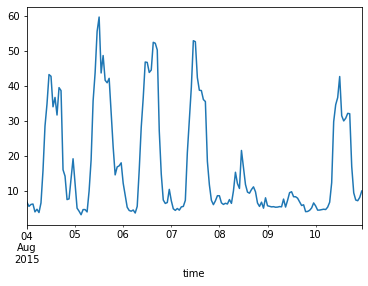

In [288]:
data_air.loc["2015-08-04 00:00:00" : "2015-08-10 23:00:00", "value_air"] = air_pred
data_air.loc["2015-08-04 00:00:00" : "2015-08-10 23:00:00", "value_air"].plot()

<h4>针对total构建模型</h4>

<h5>画图</h5>

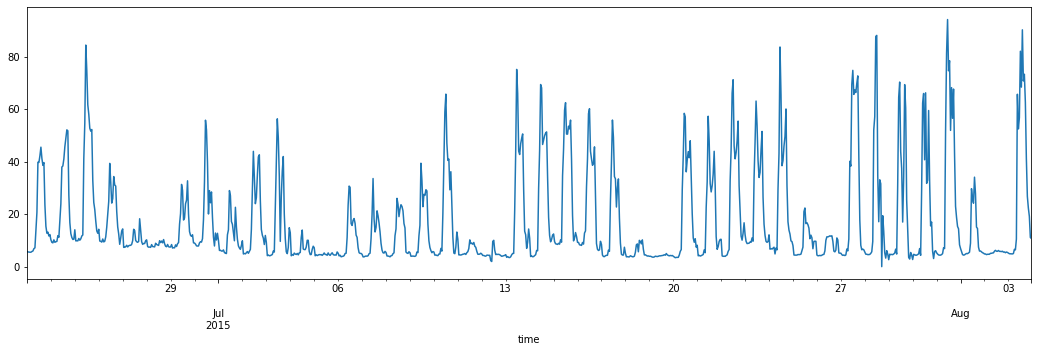

In [289]:
data["value_total"].loc["2015-06-23 00:00:00" : "2015-08-03 23:00:00"].plot(figsize=(18,5))

<h5>取出有用的数据</h5>

In [290]:
data_total = data.drop(columns=["value_air", "value_light", "value_socket"])
data_total = data_total[(data_total["value_total"] > 0) | (data_total["value_total"].isnull())]
x_train_total = data_total.drop(columns=["value_total"]).loc[: "2015-08-03 23:00:00"]
y_train_total = data_total["value_total"].loc[: "2015-08-03 23:00:00"]
x_test_total = data_total.drop(columns=["value_total"]).loc["2015-08-04 00:00:00" : "2015-08-10 23:00:00"]
sample_weight = np.arange(0, x_train_total.shape[0], 1)
sample_weight = sample_weight / np.sum(sample_weight)

<h5>构建lightgbm</h5>

In [291]:
model_total1 = LGBMRegressor(n_estimators=1000, n_jobs=-1, random_state=42).fit(x_train_total, y_train_total, sample_weight=sample_weight)
total_pred1 = model_total1.predict(x_test_total)

<h5>取最后7*24个点作为模型2预测值</h5>

In [292]:
total_pred2 = data_total.loc[: "2015-08-03 23:00:00", "value_total"].values[-7*24:]

<h5>构建catboost</h5>

In [293]:
model_total3 = CatBoostRegressor(n_estimators=1000, random_state=1024).fit(x_train_total, y_train_total, sample_weight=sample_weight)
total_pred3 = model_total3.predict(x_test_total)

Learning rate set to 0.063382
0:	learn: 17.6905082	total: 3.59ms	remaining: 3.58s
1:	learn: 16.9704111	total: 6.87ms	remaining: 3.43s
2:	learn: 16.3015203	total: 10ms	remaining: 3.33s
3:	learn: 15.6889916	total: 13.2ms	remaining: 3.27s
4:	learn: 15.1322100	total: 16.1ms	remaining: 3.2s
5:	learn: 14.6142051	total: 19ms	remaining: 3.15s
6:	learn: 14.1510650	total: 22ms	remaining: 3.13s
7:	learn: 13.7232285	total: 27.8ms	remaining: 3.45s
8:	learn: 13.3253636	total: 31ms	remaining: 3.41s
9:	learn: 12.9646395	total: 34.1ms	remaining: 3.37s
10:	learn: 12.6395653	total: 37ms	remaining: 3.33s
11:	learn: 12.3445439	total: 40ms	remaining: 3.29s
12:	learn: 12.0799873	total: 42.9ms	remaining: 3.26s
13:	learn: 11.8046983	total: 45.9ms	remaining: 3.23s
14:	learn: 11.5650978	total: 48.6ms	remaining: 3.19s
15:	learn: 11.3535368	total: 51.2ms	remaining: 3.15s
16:	learn: 11.1448010	total: 53.8ms	remaining: 3.11s
17:	learn: 10.9545275	total: 56.6ms	remaining: 3.09s
18:	learn: 10.7912392	total: 59.2ms	rem

189:	learn: 6.4482156	total: 509ms	remaining: 2.17s
190:	learn: 6.4401867	total: 511ms	remaining: 2.17s
191:	learn: 6.4311119	total: 514ms	remaining: 2.16s
192:	learn: 6.4250073	total: 517ms	remaining: 2.16s
193:	learn: 6.4151008	total: 520ms	remaining: 2.16s
194:	learn: 6.4072690	total: 522ms	remaining: 2.15s
195:	learn: 6.3988674	total: 525ms	remaining: 2.15s
196:	learn: 6.3899389	total: 527ms	remaining: 2.15s
197:	learn: 6.3865609	total: 530ms	remaining: 2.15s
198:	learn: 6.3821242	total: 532ms	remaining: 2.14s
199:	learn: 6.3760164	total: 535ms	remaining: 2.14s
200:	learn: 6.3682052	total: 538ms	remaining: 2.14s
201:	learn: 6.3637833	total: 540ms	remaining: 2.13s
202:	learn: 6.3565127	total: 543ms	remaining: 2.13s
203:	learn: 6.3428613	total: 546ms	remaining: 2.13s
204:	learn: 6.3345839	total: 548ms	remaining: 2.13s
205:	learn: 6.3279644	total: 551ms	remaining: 2.12s
206:	learn: 6.3220050	total: 554ms	remaining: 2.12s
207:	learn: 6.3101755	total: 557ms	remaining: 2.12s
208:	learn: 

392:	learn: 5.3366265	total: 1.03s	remaining: 1.59s
393:	learn: 5.3305021	total: 1.03s	remaining: 1.59s
394:	learn: 5.3281900	total: 1.04s	remaining: 1.59s
395:	learn: 5.3254786	total: 1.04s	remaining: 1.58s
396:	learn: 5.3210756	total: 1.05s	remaining: 1.59s
397:	learn: 5.3184187	total: 1.05s	remaining: 1.59s
398:	learn: 5.3149747	total: 1.05s	remaining: 1.58s
399:	learn: 5.3113918	total: 1.05s	remaining: 1.58s
400:	learn: 5.3069821	total: 1.06s	remaining: 1.58s
401:	learn: 5.3035466	total: 1.06s	remaining: 1.58s
402:	learn: 5.3004832	total: 1.06s	remaining: 1.57s
403:	learn: 5.2976929	total: 1.06s	remaining: 1.57s
404:	learn: 5.2914985	total: 1.07s	remaining: 1.57s
405:	learn: 5.2871407	total: 1.07s	remaining: 1.57s
406:	learn: 5.2816406	total: 1.07s	remaining: 1.56s
407:	learn: 5.2767408	total: 1.07s	remaining: 1.56s
408:	learn: 5.2742485	total: 1.08s	remaining: 1.56s
409:	learn: 5.2688622	total: 1.08s	remaining: 1.55s
410:	learn: 5.2658247	total: 1.08s	remaining: 1.55s
411:	learn: 

592:	learn: 4.7367897	total: 1.55s	remaining: 1.06s
593:	learn: 4.7343224	total: 1.55s	remaining: 1.06s
594:	learn: 4.7326614	total: 1.55s	remaining: 1.06s
595:	learn: 4.7301612	total: 1.55s	remaining: 1.05s
596:	learn: 4.7293019	total: 1.56s	remaining: 1.05s
597:	learn: 4.7273842	total: 1.56s	remaining: 1.05s
598:	learn: 4.7238414	total: 1.56s	remaining: 1.05s
599:	learn: 4.7228203	total: 1.57s	remaining: 1.04s
600:	learn: 4.7189383	total: 1.57s	remaining: 1.04s
601:	learn: 4.7171409	total: 1.57s	remaining: 1.04s
602:	learn: 4.7164038	total: 1.57s	remaining: 1.04s
603:	learn: 4.7143209	total: 1.58s	remaining: 1.03s
604:	learn: 4.7114552	total: 1.58s	remaining: 1.03s
605:	learn: 4.7093335	total: 1.58s	remaining: 1.03s
606:	learn: 4.7060139	total: 1.58s	remaining: 1.02s
607:	learn: 4.7045867	total: 1.59s	remaining: 1.02s
608:	learn: 4.7021544	total: 1.59s	remaining: 1.02s
609:	learn: 4.6988366	total: 1.59s	remaining: 1.02s
610:	learn: 4.6977186	total: 1.59s	remaining: 1.01s
611:	learn: 

789:	learn: 4.3393831	total: 2.06s	remaining: 546ms
790:	learn: 4.3381317	total: 2.06s	remaining: 544ms
791:	learn: 4.3367282	total: 2.06s	remaining: 541ms
792:	learn: 4.3342419	total: 2.06s	remaining: 539ms
793:	learn: 4.3317804	total: 2.06s	remaining: 536ms
794:	learn: 4.3300182	total: 2.07s	remaining: 533ms
795:	learn: 4.3291309	total: 2.07s	remaining: 531ms
796:	learn: 4.3270790	total: 2.07s	remaining: 528ms
797:	learn: 4.3253201	total: 2.08s	remaining: 526ms
798:	learn: 4.3234712	total: 2.08s	remaining: 523ms
799:	learn: 4.3226870	total: 2.08s	remaining: 520ms
800:	learn: 4.3214590	total: 2.08s	remaining: 518ms
801:	learn: 4.3193994	total: 2.09s	remaining: 515ms
802:	learn: 4.3179497	total: 2.09s	remaining: 513ms
803:	learn: 4.3169282	total: 2.09s	remaining: 510ms
804:	learn: 4.3153162	total: 2.09s	remaining: 507ms
805:	learn: 4.3119107	total: 2.1s	remaining: 505ms
806:	learn: 4.3106838	total: 2.1s	remaining: 502ms
807:	learn: 4.3094110	total: 2.1s	remaining: 500ms
808:	learn: 4.3

990:	learn: 4.0336838	total: 2.58s	remaining: 23.4ms
991:	learn: 4.0320810	total: 2.58s	remaining: 20.8ms
992:	learn: 4.0304402	total: 2.58s	remaining: 18.2ms
993:	learn: 4.0294346	total: 2.58s	remaining: 15.6ms
994:	learn: 4.0271930	total: 2.59s	remaining: 13ms
995:	learn: 4.0255484	total: 2.59s	remaining: 10.4ms
996:	learn: 4.0241149	total: 2.59s	remaining: 7.8ms
997:	learn: 4.0227553	total: 2.59s	remaining: 5.2ms
998:	learn: 4.0209229	total: 2.6s	remaining: 2.6ms
999:	learn: 4.0198150	total: 2.6s	remaining: 0us


<h5>构建深度模型</h5>

In [294]:
data = pd.merge(data_dict["二层插座"],data_dict["二层照明"],on='time', how="inner", suffixes=("_socket_2","_light_2"))
data = pd.merge(data,data_dict["一层插座"],on='time', how="inner", suffixes=("","_socket_1"))
data = pd.merge(data,data_dict["一层照明"],on='time', how="inner", suffixes=("","_light_1"))
data = pd.merge(data,data_dict["空调"],on='time', how="inner", suffixes=("","_air"))
data = data.rename(columns={"value":"value_socket_1"})
data["value_socket"] = data["value_socket_2"] + data["value_socket_1"]
data["value_light"] = data["value_light_2"] + data["value_light_1"]
data.drop(['value_socket_2','value_light_2','value_socket_1','value_light_1'], axis=1, inplace=True)
data["value_total"] = data.sum(axis=1)
data = data.set_index("time", drop=True)
data = data.reindex(pd.date_range(start=data.index[0], end=data.index[-1], freq="15T"))
data["value_air"] = data["value_air"].interpolate(method="linear")
data["value_light"] = data["value_light"].interpolate(method="linear")
data["value_socket"] = data["value_socket"].interpolate(method="linear")
data["value_total"] = data["value_total"].interpolate(method="linear")
data = data.resample("1H").sum()
data.loc["2014-03-14 13:00:00" : "2014-04-23 20:00:00", :] = np.nan
data.loc["2014-11-17 08:00:00" : "2014-12-10 16:00:00", :] = np.nan
data = pd.merge(data, wh, how="right", left_index=True, right_index=True)
data = data.rename(columns={
    "温度(C°)":"temp",
    "湿度(%)":"humidity",
    "降雨量(mm)":"rainfall",
    "大气压(hPa)":"atmos",
    "风向":"wind_direction",
    "风向角度(°)":"wind_angle",
    "风速(KM/H)":"wind_speed",
    "云量(%)":"cloud"
})
data['workday'] = list(map(lambda x: int(is_workday(x)), data.index.to_list()))
data['hour'] = list(map(lambda x: x.hour, data.index.to_list()))
data['week'] = list(map(lambda x: x.weekday(), data.index.to_list()))
data['day'] = list(map(lambda x: x.day, data.index.to_list()))
data['month'] = list(map(lambda x: x.month, data.index.to_list()))
data['year'] = list(map(lambda x: x.year, data.index.to_list()))
onehot_wind = OneHotEncoder(sparse=False)
onehot_wind.fit(data[["wind_direction"]])
data = pd.concat([data, DataFrame(onehot_wind.transform(data[["wind_direction"]]), columns=onehot_wind.categories_[0], index=data.index).astype(int)], axis=1)
data = data.drop(columns=["wind_direction"])
data["week"] = data["week"].apply(lambda x: "星期" + str(x + 1))
onehot_week = OneHotEncoder(sparse=False)
onehot_week.fit(data[["week"]])
data = pd.concat([data, DataFrame(onehot_week.transform(data[["week"]]), columns=onehot_week.categories_[0], index=data.index).astype(int)], axis=1)
data = data.drop(columns=["week"])
data_total = data.drop(columns=["value_air", "value_light", "value_socket"])

In [295]:
@tf.function
def split_xy(x):
    return x[:, :, 1:], x[:, :, 0]

In [296]:
ds_total1 = timeseries_dataset_from_array(
    data=data_total.loc[: "2014-03-14 12:00:00"].values,
    targets=None,
    sequence_length=7 * 24,
    sequence_stride=1,
    batch_size=128,
    shuffle=True,
    seed=42
)
ds_total2 = timeseries_dataset_from_array(
    data=data_total.loc["2014-04-23 21:00:00" : "2014-11-17 07:00:00"].values,
    targets=None,
    sequence_length=7 * 24,
    sequence_stride=1,
    batch_size=128,
    shuffle=True,
    seed=42
)
ds_total3 = timeseries_dataset_from_array(
    data=data_total.loc["2014-12-10 17:00:00" : "2015-08-03 23:00:00"].values,
    targets=None,
    sequence_length=7 * 24,
    sequence_stride=1,
    batch_size=128,
    shuffle=True,
    seed=42
)
ds_total = ds_total1.concatenate(ds_total2).concatenate(ds_total3).map(split_xy)
ds_total

<MapDataset shapes: ((None, None, 27), (None, None)), types: (tf.float64, tf.float64)>

Epoch 1/100
122/122 [==============================] - 35s 286ms/step - loss: 503.0653 - mae: 15.4450
Epoch 2/100
122/122 [==============================] - 36s 299ms/step - loss: 402.6721 - mae: 14.1782
Epoch 3/100
122/122 [==============================] - 37s 300ms/step - loss: 215.9896 - mae: 9.1900
Epoch 4/100
122/122 [==============================] - 42s 346ms/step - loss: 150.3401 - mae: 7.6101
Epoch 5/100
122/122 [==============================] - 46s 375ms/step - loss: 115.1468 - mae: 6.6530
Epoch 6/100
122/122 [==============================] - 45s 369ms/step - loss: 90.2335 - mae: 5.8798
Epoch 7/100
122/122 [==============================] - 45s 370ms/step - loss: 76.0030 - mae: 5.4224
Epoch 8/100
122/122 [==============================] - 44s 365ms/step - loss: 63.9302 - mae: 5.0007
Epoch 9/100
122/122 [==============================] - 44s 365ms/step - loss: 54.8073 - mae: 4.6585
Epoch 10/100
122/122 [==============================] - 44s 362ms/step - loss: 48.2718 - mae:

122/122 [==============================] - 37s 302ms/step - loss: 4.4907 - mae: 1.2530
Epoch 83/100
122/122 [==============================] - 37s 301ms/step - loss: 4.4387 - mae: 1.2410
Epoch 84/100
122/122 [==============================] - 37s 301ms/step - loss: 4.5300 - mae: 1.2527
Epoch 85/100
122/122 [==============================] - 37s 302ms/step - loss: 4.1708 - mae: 1.2021
Epoch 86/100
122/122 [==============================] - 37s 302ms/step - loss: 4.2661 - mae: 1.2112
Epoch 87/100
122/122 [==============================] - 37s 302ms/step - loss: 4.2346 - mae: 1.2088
Epoch 88/100
122/122 [==============================] - 37s 303ms/step - loss: 4.0623 - mae: 1.1780
Epoch 89/100
122/122 [==============================] - 37s 303ms/step - loss: 4.0364 - mae: 1.1736
Epoch 90/100
122/122 [==============================] - 37s 302ms/step - loss: 3.9813 - mae: 1.1602
Epoch 91/100
122/122 [==============================] - 37s 302ms/step - loss: 3.9346 - mae: 1.1578
Epoch 92/100


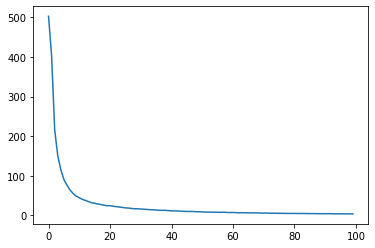

In [297]:
model_total4 = Sequential([
    BatchNormalization(axis=-1, input_shape=(None, 27)),
    LSTM(units=32, return_sequences=True, return_state=False),
    LSTM(units=64, return_sequences=True, return_state=False),
    LSTM(units=128, return_sequences=True, return_state=False),
    TimeDistributed(Dense(units=32, activation="relu")),
    TimeDistributed(Dense(units=16, activation="relu")),
    TimeDistributed(Dense(units=1, activation=None))
])
model_total4.compile(
    optimizer=Adam(),
    loss=MeanSquaredError(),
    metrics=["mae"]
)
try:
    model_total4.load_weights("../models/LSTM.h5")
except OSError as e:
    logging.info("loading LSTM model from ../models/LSTM.h5")
    history = model_total4.fit(
        ds_total,
        batch_size=128,
        epochs=100,
        workers=12,
        use_multiprocessing=True
    )
    model_total4.save_weights("../models/LSTM.h5")
    plt.figure()
    plt.plot(history.history["loss"])
    plt.show()

In [298]:
x_test_total = np.expand_dims(data_total.drop(columns=["value_total"]).loc["2015-08-04 00:00:00" : "2015-08-10 23:00:00"].values, 0)
total_pred4 = model_total4.predict(x_test_total)[0, :, 0]

<h5>模型融合</h5>

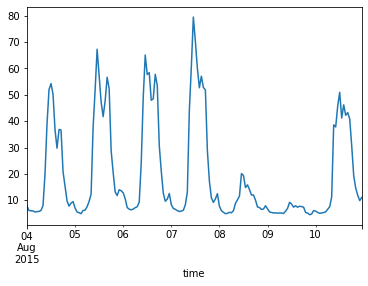

In [300]:
total_pred = (total_pred1 + total_pred2 + total_pred3 + total_pred4) / 4
data_total.loc["2015-08-04 00:00:00" : "2015-08-10 23:00:00", "value_total"] = total_pred
data_total.loc["2015-08-04 00:00:00" : "2015-08-10 23:00:00", "value_total"].plot()

<h3>预测未来七天的各项能耗，并输出用于评测的.csv文件：</h3>

In [301]:
results = DataFrame(index=pd.date_range(start="2015-08-04 00:00:00", end="2015-08-10 23:00:00", freq="1H"))
results['socket'] = clip_value(socket_pred, _min_val_=0)
results['light'] = clip_value(light_pred, _min_val_=0)
results['air'] = clip_value(air_pred, _min_val_=0)
results['total'] = clip_value(total_pred, _min_val_=0)
results = results[["total", "socket", "light", "air"]]
filename = "submit_%s.csv" % datetime.now().strftime("%Y-%m-%dT%H-%M")

results.to_csv(os.path.join("../data", filename), index=False)
results

,total,socket,light,air
2015-08-04 00:00:00,7.913713,1.013156,0.980768,6.734997
2015-08-04 01:00:00,6.136646,0.707864,0.469409,5.557494
2015-08-04 02:00:00,5.999362,0.713578,0.426918,6.105355
2015-08-04 03:00:00,5.971694,0.612697,0.362561,6.225344
2015-08-04 04:00:00,5.565055,0.744236,0.222480,3.986586
...,...,...,...,...
2015-08-10 19:00:00,19.259445,1.574388,3.976589,9.430746
2015-08-10 20:00:00,14.590824,1.176799,2.079805,7.371095
2015-08-10 21:00:00,11.890767,1.251589,1.707284,7.174668
2015-08-10 22:00:00,9.898539,1.117862,1.753497,8.123187


In [302]:
with ZipFile('../data/test.zip', 'w') as zip_file:
    zip_file.write(os.path.join("../data", filename), filename, compress_type=zipfile.ZIP_DEFLATED)